In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf
from enum import Enum
import cv2
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from keras_adabound import AdaBound
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, SpatialDropout2D,
    AvgPool2D, MaxPool2D, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D,
    Flatten, Dense
)
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.applications import (
    ResNet152V2, ResNet50, DenseNet169,DenseNet121
)
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from keras.callbacks import ModelCheckpoint
import datetime
from skimage.transform import rescale, resize
import keras
import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import keras.utils
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn

/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Set seed in order to maintain the Train/ Test/ Valid contents in any environment.

In [2]:
# define seed number to have reproducible experiments.
seed = 3352024
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
def load_path(path):
    
    '''
    load MURA dataset
    '''
    dataset = [] 
    for body in os.listdir(path):
        body_part = body
        path_p = path+'/'+str(body)
        for id_p in os.listdir(path_p):
            patient_id = id_p
            path_id = path_p+'/'+str(id_p)
            for lab in os.listdir(path_id):
                if lab.split('_')[-1]=='positive': 
                    label = 1 
                elif lab.split('_')[-1]=='negative':
                    label= 0
                path_l = path_id+'/'+str(lab)
                for img in os.listdir(path_l):  
                    img_path = path_l + '/' + str(img)
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

### Set the path where you stored your dataset

In [5]:
path = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/train'
os.listdir(path)

['XR_ELBOW']

In [6]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train.head()

,body_part,patient_id,label,img_path
0,XR_ELBOW,patient02946,0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
1,XR_ELBOW,patient02946,0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
2,XR_ELBOW,patient05951,0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
3,XR_ELBOW,patient05951,0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
4,XR_ELBOW,patient05509,0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...


In [7]:
dataset_test = load_path(path = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/valid')
df_test = pd.DataFrame(dataset_test)
df_test.head()

,body_part,patient_id,label,img_path
0,XR_ELBOW,patient11793,1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
1,XR_ELBOW,patient11793,1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
2,XR_ELBOW,patient11793,1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
3,XR_ELBOW,patient11793,1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
4,XR_ELBOW,patient11793,1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...


## Train
### Set the path where you stored your train csv accordingly.

In [8]:
#csv files path
path = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1'
train_image_paths_csv = "MURA_ELBOW_Train_ImagePath.csv"

In [9]:
train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
train_images_paths.columns = ['image_path']

In [10]:
train_images_paths['label'] = train_images_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
train_images_paths['category']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[3])  
train_images_paths['patientId']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[4].replace('patient',''))
train_images_paths.head()

,image_path,label,category,patientId
0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project
1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project
2,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project
3,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project
4,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project


## Valid
### Set the path where you stored your valid csv accordingly.

In [11]:
path = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1'
valid_image_paths_csv = "MURA_ELBOW_Valid_ImagePath.csv"
valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
valid_data_paths.columns = ['image_path']

In [12]:
valid_data_paths['label'] = valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid_data_paths['category']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[3])  
valid_data_paths['dir'] =  valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
valid_data_paths['patientId']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[4].replace('patient',''))
valid_data_paths.head()

,image_path,label,category,dir,patientId
0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project
1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project
2,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project
3,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project
4,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project


In [13]:
train_images_paths['label_index']= train_images_paths.label
train_images_paths.label_index.replace('positive', 1, inplace=True)
train_images_paths.label_index.replace('negative', 0, inplace=True)
train_images_paths.head()

,image_path,label,category,patientId,label_index
0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project,1
1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project,1
2,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project,1
3,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project,1
4,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project,1


In [14]:
valid_data_paths['label_index']= valid_data_paths.label
valid_data_paths.label_index.replace('positive', 1, inplace=True)
valid_data_paths.label_index.replace('negative', 0, inplace=True)
valid_data_paths.head()

,image_path,label,category,dir,patientId,label_index
0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project,1
1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project,1
2,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project,1
3,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project,1
4,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project,1


### Data Preprocessing

In [15]:
im_size = 224

In [16]:
def random_rotation_flip(image,size = 224):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

In [17]:
def image_loader(Path, size = 224): 
    Images = []
    for path in tqdm(Path):
        try:
            image = cv2.imread(path)
            image = random_rotation_flip(image,size)
            Images.append(image)
        except Exception as e:
            print(str(e))   
    return Images

In [18]:
#X_train = image_loader(train_images_paths['image_path'][:50,],im_size)
X_train = image_loader(train_images_paths['image_path'],im_size)

100%|██████████| 4931/4931 [00:21<00:00, 228.34it/s]


In [19]:
y_train = train_images_paths['label']
y_train

0       positive
1       positive
2       positive
3       positive
4       positive
          ...   
4926    negative
4927    negative
4928    negative
4929    negative
4930    negative
Name: label, Length: 4931, dtype: object

In [20]:
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

In [21]:
X_test = image_loader(valid_data_paths['image_path'],im_size)

100%|██████████| 465/465 [00:01<00:00, 248.71it/s]


In [22]:
y_test = valid_data_paths['label']

In [23]:
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

## Applying Train and Test Spliting Function

In [24]:
train, valid = train_test_split(train_images_paths, test_size=0.2,random_state=seed)

In [25]:
test = valid_data_paths.drop(['dir'], axis=1)

In [26]:
im_size = 224

### Generating Train/Valid/Test generators

In [27]:
image_generator = ImageDataGenerator()

In [28]:
train_generator = image_generator.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest', validate_filenames=False,seed=seed)

Found 3944 non-validated image filenames.
Found 987 non-validated image filenames.
Found 465 non-validated image filenames.


In [29]:
CLASSES = 2
input_shape = (im_size,im_size,3)

## Applying Metric-AUC,BinaryAccuracy and CohenKappa

In [30]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

## Generating AUC, Loss and Kappa Loss plots for evaluation.

In [31]:
def plot_history(hs, epochs, metric):
    if metric=='loss': 
                label_y = 'Loss'
    elif metric=='accuracy': 
               label_y = 'Accuracy'
    elif metric=='auc': 
               label_y = 'AUC'
    else : label_y = 'kappa'
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

def print_results(model_name,epochs,hs,model_eval):
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))
    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

### Model Cleanup

In [34]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

## Setting ReducedLROnPlateau and Earlystopping configurations as CallBacks.

In [35]:
my_callbacks = [
                keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',     # Reduce learning rate when a metric has stopped improving.
                                                      factor=0.1,
                                                      patience=3,
                                                      min_delta=0.001,
                                                      verbose=1,
                                                      min_lr=0.000000001),
                keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3, #5
                                                  mode="max",
                                                  baseline=None,
                                                  restore_best_weights=True)
                ]

# Applying Deep Learning Models

### RESNET50 Pre-trained Model

In [33]:
def ResNet50PreBuilder(pooling="max", shape=(224, 224, 3), trainable_layers_after=None):
    base_model_res = ResNet50(input_shape= shape, include_top=False, weights="imagenet", pooling= pooling)
    for layer in base_model_res.layers:
        layer.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",name="RESNET50_output_sigmoid")
    model = Sequential(layers=[base_model_res,prediction_layer],name="RESNET50")
    return model 

94765736/94765736 [==============================] - 38s 0us/step
Epoch 1/15
62/62 [==============================] - 525s 8s/step - loss: 0.6272 - auc: 0.6743 - accuracy: 0.6575 - kappa: 0.2599 - val_loss: 0.5912 - val_auc: 0.7381 - val_accuracy: 0.7133 - val_kappa: 0.3942 - lr: 0.0010
Epoch 2/15
62/62 [==============================] - 492s 8s/step - loss: 0.5362 - auc: 0.7864 - accuracy: 0.7345 - kappa: 0.4310 - val_loss: 0.5465 - val_auc: 0.7732 - val_accuracy: 0.7467 - val_kappa: 0.4374 - lr: 0.0010
Epoch 3/15
62/62 [==============================] - 472s 8s/step - loss: 0.5061 - auc: 0.8122 - accuracy: 0.7639 - kappa: 0.4937 - val_loss: 0.5685 - val_auc: 0.7850 - val_accuracy: 0.7335 - val_kappa: 0.4524 - lr: 0.0010
Epoch 4/15
62/62 [==============================] - 505s 8s/step - loss: 0.4851 - auc: 0.8303 - accuracy: 0.7756 - kappa: 0.5204 - val_loss: 0.5252 - val_auc: 0.7945 - val_accuracy: 0.7629 - val_kappa: 0.4718 - lr: 0.0010
Epoch 5/15
62/62 [============================

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved C:/KNNT/Personal/Freelance/MURA_trained/finalModel/model_RESNET50Final_ORG.h5
8/8 [==============================] - 40s 5s/step - loss: 0.5203 - auc: 0.8294 - accuracy: 0.7484 - kappa: 0.4953
...Finished clean up...
Train Loss     : 0.41663
Validation Loss: 0.50651
Test Loss      : 0.52029
---
Train AUC     : 0.88041
Validation AUC: 0.81569
Test AUC      : 0.82942
---
Train Accuracy     : 0.82683
Validation Accuracy: 0.78115
Test Accuracy      : 0.74839
---
Train Kappa     : 0.63068
Validation Kappa: 0.63068
Test Kappa      : 0.49534


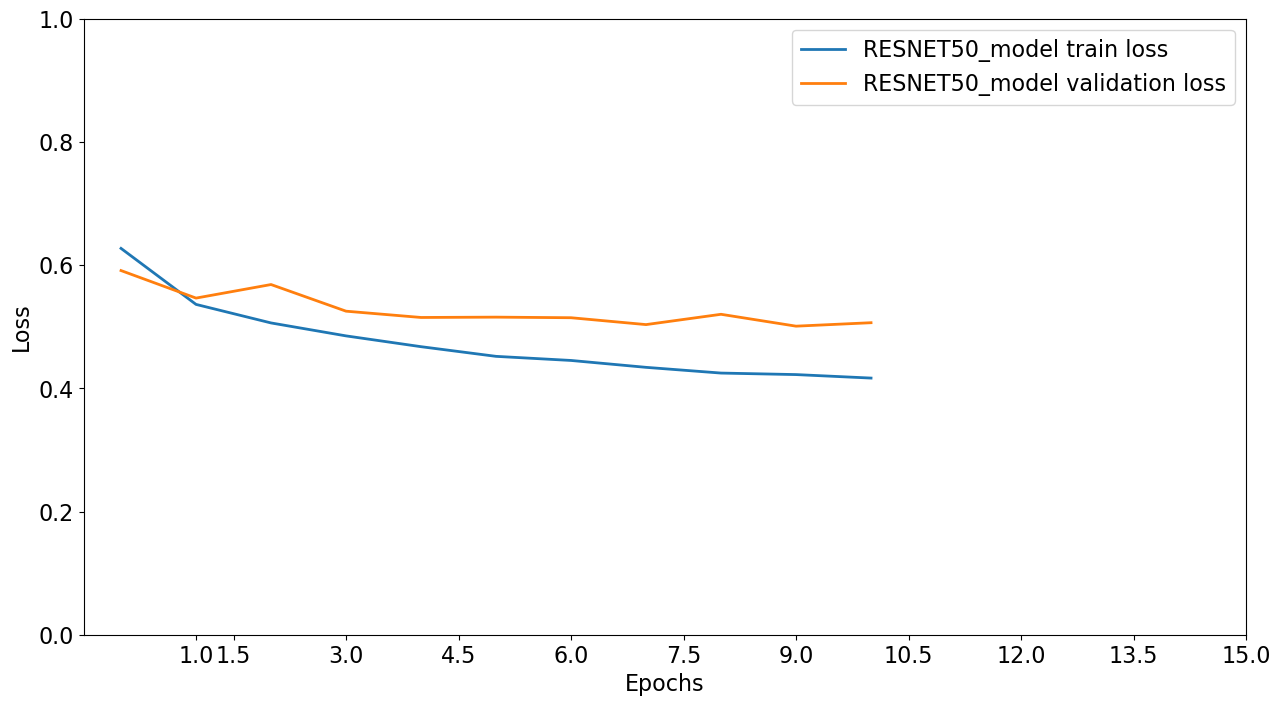

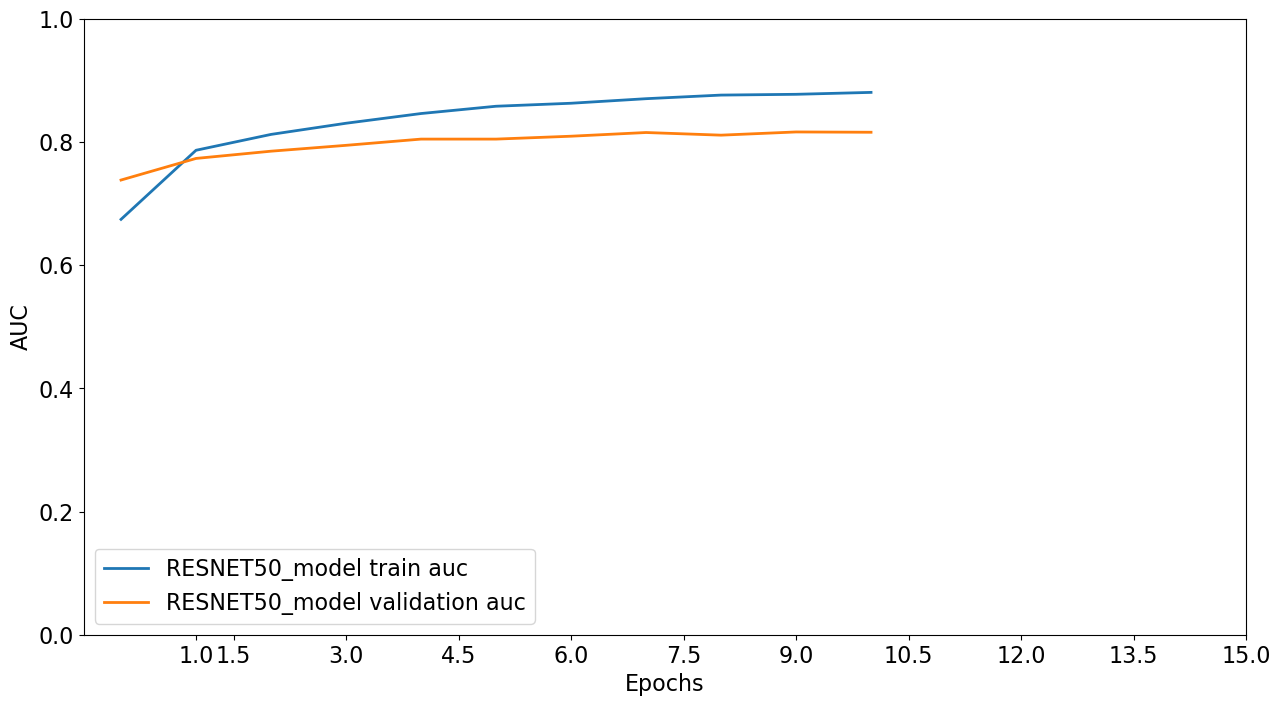

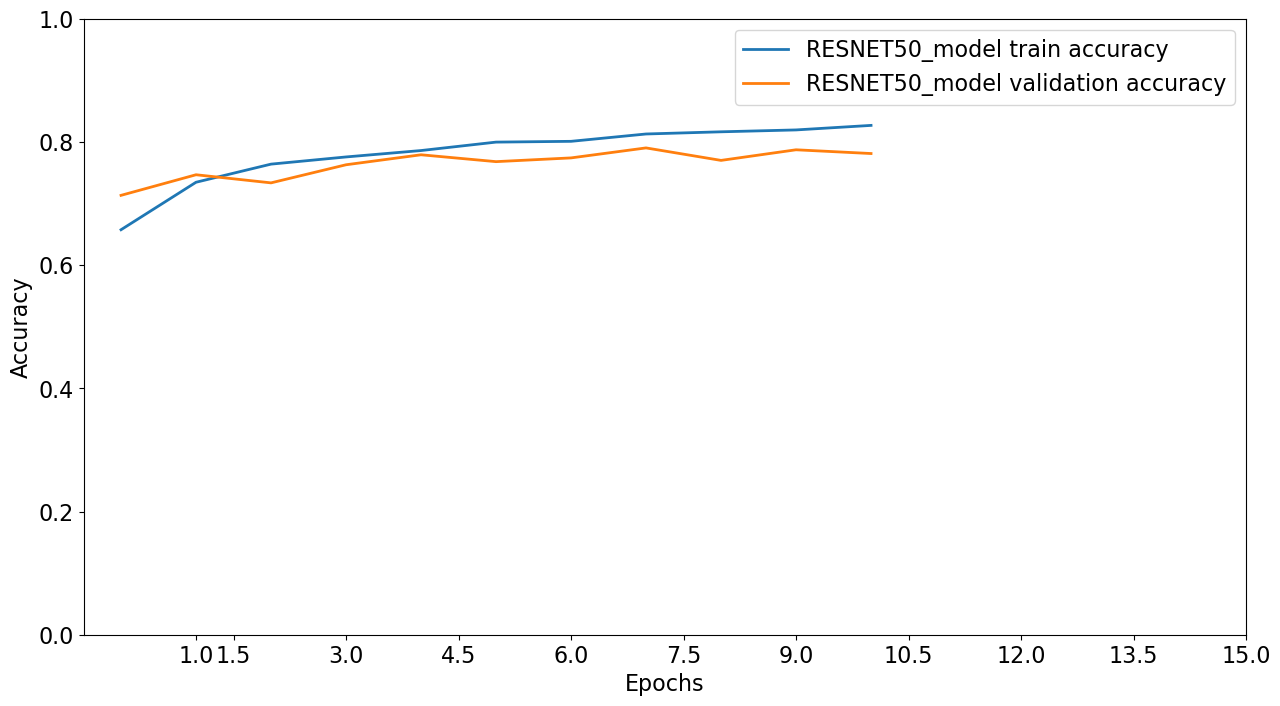

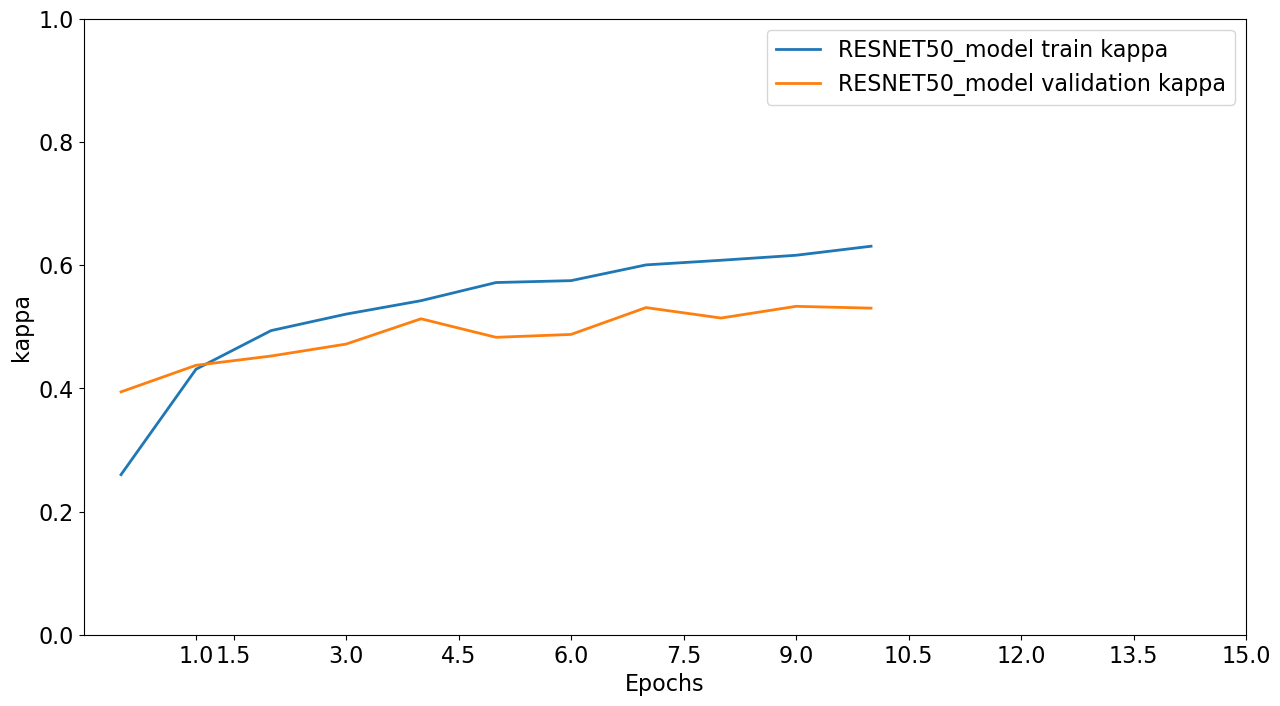

In [34]:
epochs = 15
RESNET50_model = ResNet50PreBuilder(pooling='avg')
RESNET50_model.compile(optimizer=Adam(learning_rate= 0.001), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = RESNET50_model.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks= my_callbacks)
print('Finished training.')
print('------------------')
RESNET50_model.summary()
filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_RESNET50Final_ORG.h5'
#filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_RESNET50Final_CLAHE.h5'
RESNET50_model.save(filename)
print('>Saved %s' % filename)
RESNET50_model_eval = RESNET50_model.evaluate(test_generator)
clean_up(model=RESNET50_model)
print_results(model_name='RESNET50_model',epochs= epochs,hs = hs,model_eval = RESNET50_model_eval)

## Applying Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model
# Tensorflow addons for matrix
import keras.utils
#from keras.utils import tf_utils
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn

### Train Data

62/62 [==============================] - 386s 6s/step


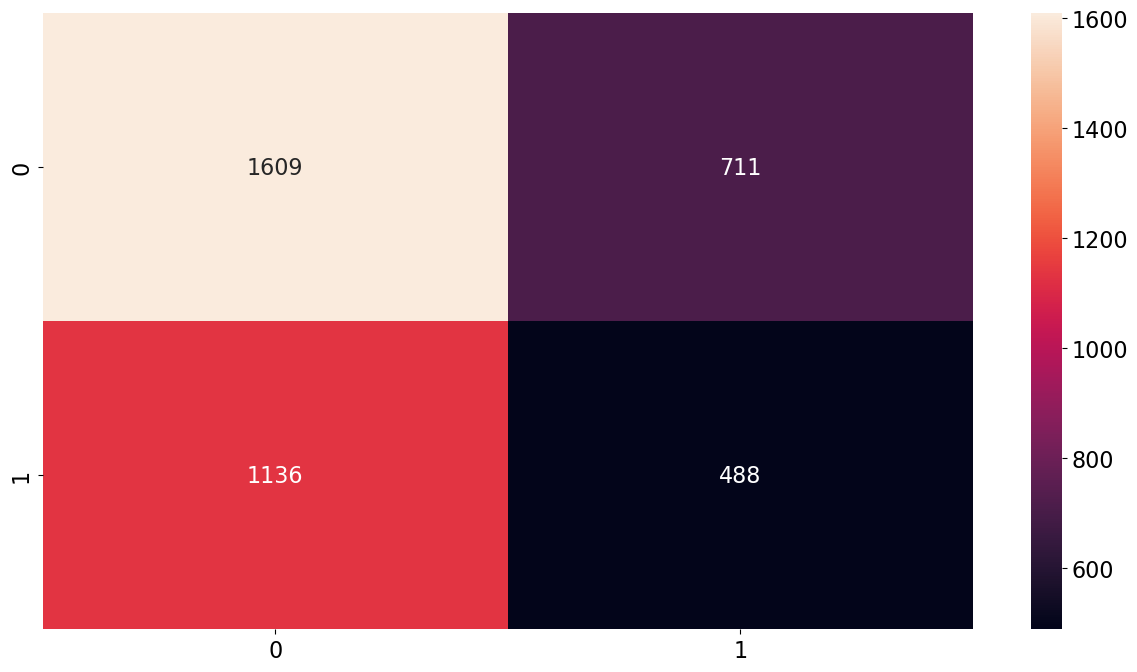

In [38]:
y_pred_train= RESNET50_model.predict(train_generator) # validate Predictions
y_train = train.label_index.values
y_pred_train_binary = [1 if val >= 0.5 else 0 for val in y_pred_train.ravel()]
cm = confusion_matrix(y_train,y_pred_train_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [39]:
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 488
True Negatives: 1609
False Positives: 711
False Negatives: 1136


### Valid Data

16/16 [==============================] - 92s 6s/step


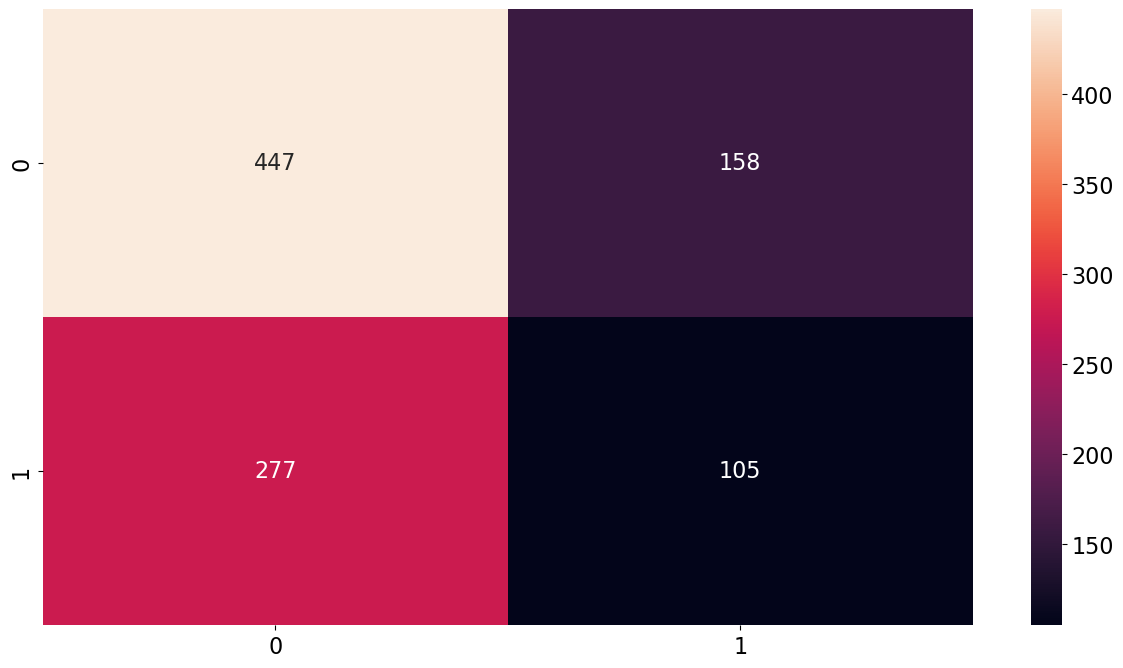

In [40]:
y_pred_valid= RESNET50_model.predict(valid_generator)
y_valid = valid.label_index.values
y_pred_binary = [1 if val >= 0.5 else 0 for val in y_pred_valid.ravel()]
cm = confusion_matrix(y_valid,y_pred_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [41]:
tn, fp, fn, tp = confusion_matrix(y_valid,y_pred_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 105
True Negatives: 447
False Positives: 158
False Negatives: 277


### Test Data

8/8 [==============================] - 43s 5s/step


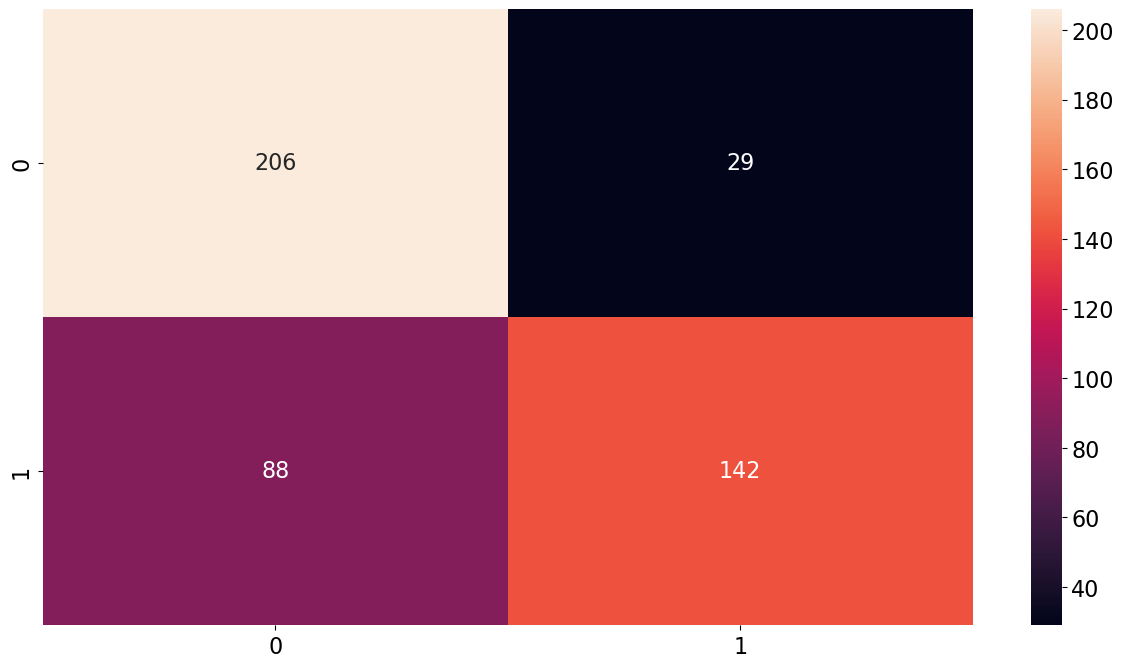

In [42]:
y_pred_test=  RESNET50_model.predict(test_generator) 
y_test = test.label_index.values
y_pred_test_binary = [1 if val >= 0.5 else 0 for val in y_pred_test.ravel()]
cm = confusion_matrix(y_test,y_pred_test_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 142
True Negatives: 206
False Positives: 29
False Negatives: 88


### VGG16 Pre-trained Model

In [36]:
from keras import layers
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense

In [37]:
import tensorflow as tf 
from tensorflow.keras.applications.vgg16 import VGG16

base_model_vgg = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model_vgg.layers:
    layer.trainable = False
    
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model_vgg.output)

# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = layers.Dense(512, activation='relu')(x)

# # Add a dropout rate of 0.5
# x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

VGG16_model = tf.keras.models.Model(base_model_vgg.input, x)    

Epoch 1/15
62/62 [==============================] - 1132s 18s/step - loss: 2.2050 - auc: 0.6943 - accuracy: 0.6640 - kappa: 0.3095 - val_loss: 1.5899 - val_auc: 0.7489 - val_accuracy: 0.7366 - val_kappa: 0.4107 - lr: 0.0010
Epoch 2/15
62/62 [==============================] - 1418s 23s/step - loss: 0.7159 - auc: 0.8931 - accuracy: 0.8309 - kappa: 0.6500 - val_loss: 1.4026 - val_auc: 0.7801 - val_accuracy: 0.7335 - val_kappa: 0.4424 - lr: 0.0010
Epoch 3/15
62/62 [==============================] - 1463s 24s/step - loss: 0.3618 - auc: 0.9504 - accuracy: 0.8889 - kappa: 0.7709 - val_loss: 1.4270 - val_auc: 0.7823 - val_accuracy: 0.7639 - val_kappa: 0.4949 - lr: 0.0010
Epoch 4/15
62/62 [==============================] - 1336s 22s/step - loss: 0.2682 - auc: 0.9678 - accuracy: 0.9156 - kappa: 0.8254 - val_loss: 1.4481 - val_auc: 0.7886 - val_accuracy: 0.7497 - val_kappa: 0.4698 - lr: 0.0010
Epoch 5/15
62/62 [==============================] - 1436s 23s/step - loss: 0.1371 - auc: 0.9876 - accura

/usr/local/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved /Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_VGG16Final_ORG.h5
8/8 [==============================] - 101s 12s/step - loss: 1.9632 - auc: 0.7523 - accuracy: 0.7161 - kappa: 0.4307
...Finished clean up...
Train Loss     : 0.01987
Validation Loss: 1.48599
Test Loss      : 1.96324
---
Train AUC     : 0.99980
Validation AUC: 0.79256
Test AUC      : 0.75233
---
Train Accuracy     : 0.99341
Validation Accuracy: 0.77001
Test Accuracy      : 0.71613
---
Train Kappa     : 0.98638
Validation Kappa: 0.98638
Test Kappa      : 0.43067


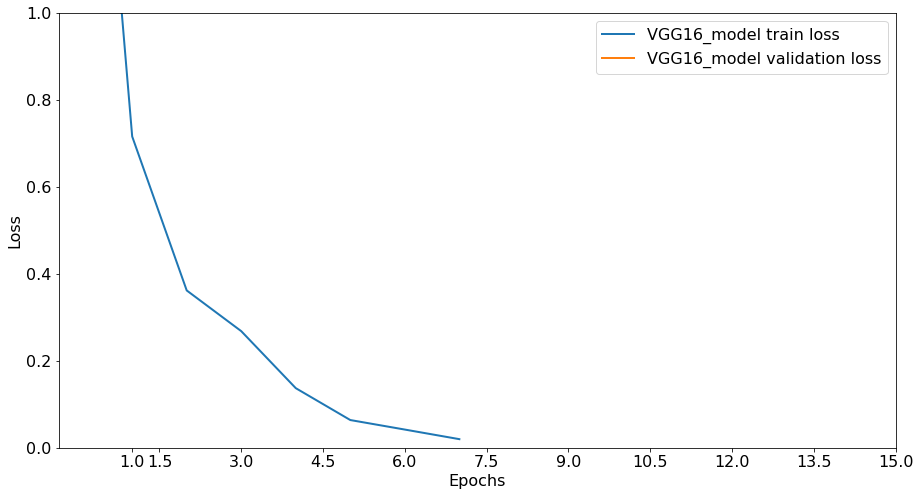

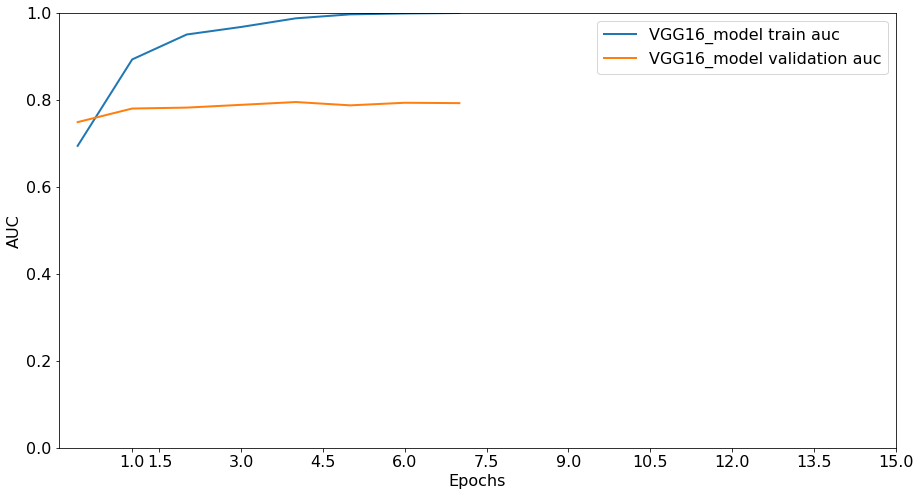

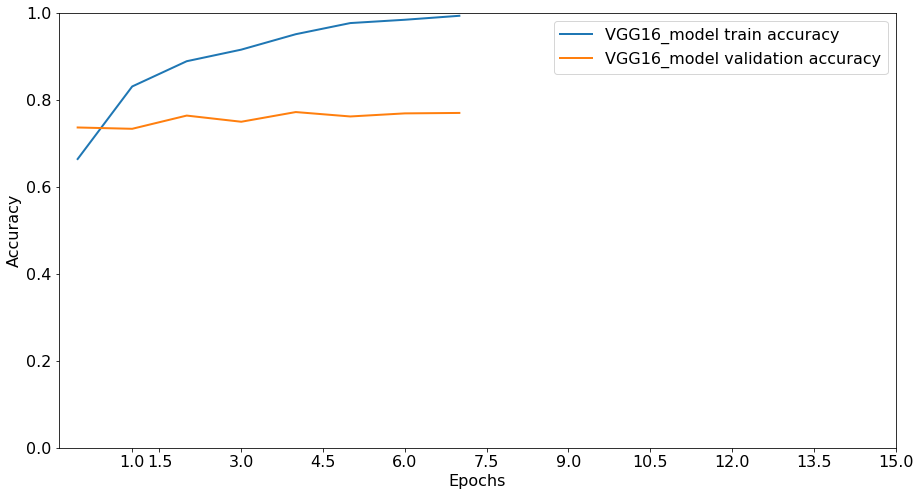

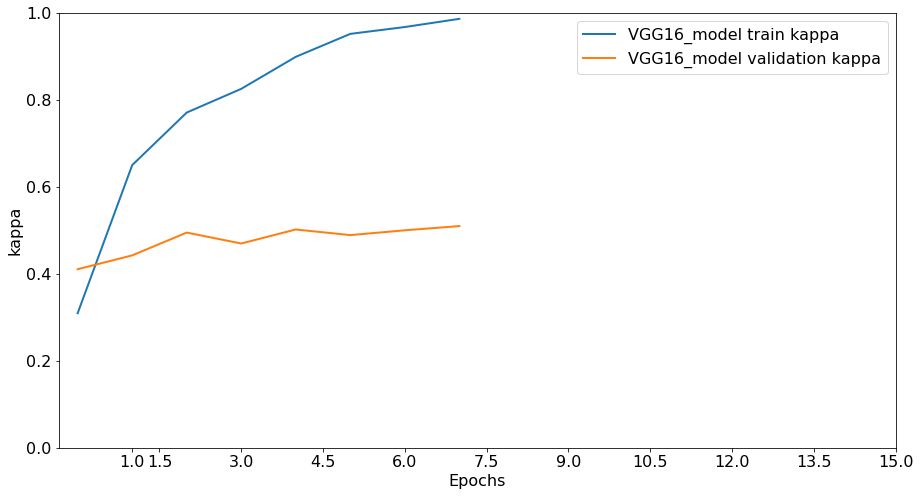

In [38]:
epochs = 15
VGG16_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = VGG16_model.fit(train_generator,validation_data = valid_generator, epochs = epochs, callbacks = my_callbacks)
print('Finished training.')
print('------------------')
VGG16_model.summary()
filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_VGG16Final_ORG.h5'
#filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_VGG16Final_CLAHE.h5'
VGG16_model.save(filename)
print('>Saved %s' % filename)
VGG16_model_eval = VGG16_model.evaluate(test_generator)
clean_up(model=VGG16_model)
print_results(model_name='VGG16_model',epochs= epochs,hs = hs,model_eval = VGG16_model_eval)

## Applying Confusion Matrix

### Train Data

62/62 [==============================] - 860s 14s/step


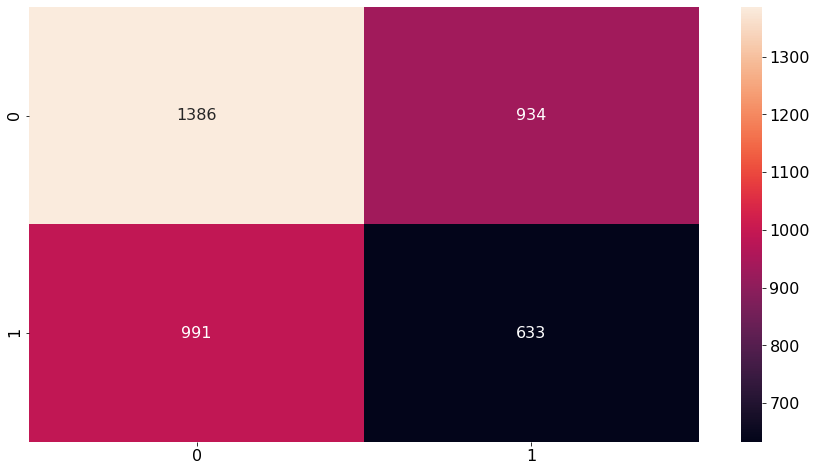

In [39]:
y_pred_train= VGG16_model.predict(train_generator) # validate Predictions
y_train = train.label_index.values
y_pred_train_binary = [1 if val >= 0.5 else 0 for val in y_pred_train.ravel()]
cm = confusion_matrix(y_train,y_pred_train_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [40]:
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 633
True Negatives: 1386
False Positives: 934
False Negatives: 991


### Valid Data

16/16 [==============================] - 215s 13s/step


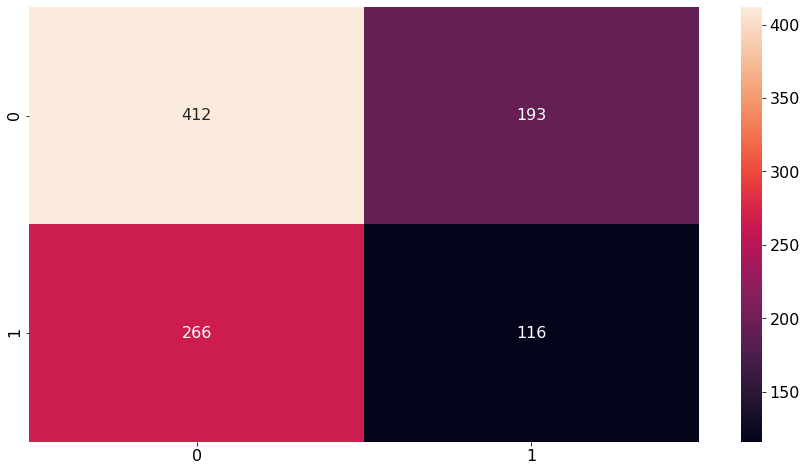

In [41]:
y_pred_valid= VGG16_model.predict(valid_generator)
y_valid = valid.label_index.values
y_pred_binary = [1 if val >= 0.5 else 0 for val in y_pred_valid.ravel()]
cm = confusion_matrix(y_valid,y_pred_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [42]:
tn, fp, fn, tp = confusion_matrix(y_valid,y_pred_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 116
True Negatives: 412
False Positives: 193
False Negatives: 266


### Test Data

8/8 [==============================] - 103s 13s/step


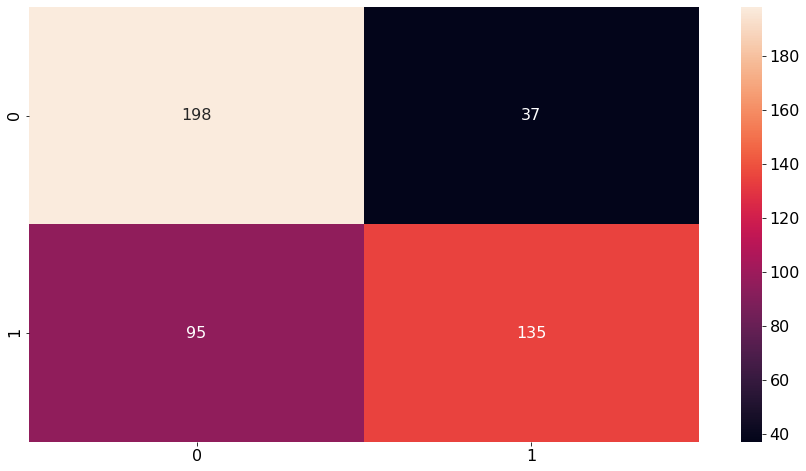

In [43]:
y_pred_test=  VGG16_model.predict(test_generator) 
y_test = test.label_index.values
y_pred_test_binary = [1 if val >= 0.5 else 0 for val in y_pred_test.ravel()]
cm = confusion_matrix(y_test,y_pred_test_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [44]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 135
True Negatives: 198
False Positives: 37
False Negatives: 95


### DenseNet121 Pre-trained Model

In [34]:
def build_model():
    base_model = keras.applications.DenseNet121(input_shape=(224, 224,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')
    for layer in base_model.layers:
        layer.trainable=False



    x = base_model.output
    predictions = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

dense_model = build_model()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20252\2356793675.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hs = dense_model.fit_generator(train_generator,validation_data = valid_generator, epochs = epochs,callbacks= my_callbacks)


Epoch 1/20
62/62 [==============================] - 529s 8s/step - loss: 0.9993 - auc: 0.5271 - accuracy: 0.5431 - kappa: 0.0294 - val_loss: 0.7382 - val_auc: 0.5635 - val_accuracy: 0.5522 - val_kappa: 0.0625 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 499s 8s/step - loss: 0.7238 - auc: 0.5738 - accuracy: 0.5690 - kappa: 0.0736 - val_loss: 0.6956 - val_auc: 0.5836 - val_accuracy: 0.5937 - val_kappa: 0.0578 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 504s 8s/step - loss: 0.6862 - auc: 0.6197 - accuracy: 0.6037 - kappa: 0.1521 - val_loss: 0.6718 - val_auc: 0.6190 - val_accuracy: 0.5957 - val_kappa: 0.1342 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 492s 8s/step - loss: 0.6623 - auc: 0.6466 - accuracy: 0.6293 - kappa: 0.2056 - val_loss: 0.6600 - val_auc: 0.6407 - val_accuracy: 0.6028 - val_kappa: 0.1515 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 467s 8s/step - loss: 0.6434 - auc: 0.6739 - accuracy: 0.6511

                                                                                                  
 conv2_block2_0_bn (BatchNo  (None, 56, 56, 96)           384       ['conv2_block1_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block2_0_relu (Activ  (None, 56, 56, 96)           0         ['conv2_block2_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block2_1_conv (Conv2  (None, 56, 56, 128)          12288     ['conv2_block2_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_blo

 tenate)                                                             'conv2_block5_2_conv[0][0]'] 
                                                                                                  
 conv2_block6_0_bn (BatchNo  (None, 56, 56, 224)          896       ['conv2_block5_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block6_0_relu (Activ  (None, 56, 56, 224)          0         ['conv2_block6_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block6_1_conv (Conv2  (None, 56, 56, 128)          28672     ['conv2_block6_0_relu[0][0]'] 
 D)                                                                                               
          

                                                                                                  
 conv3_block3_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block3_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block3_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 D)                                                                                               
                                                                                                  
 conv3_block7_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block7_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block7_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block7_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block7_1_relu[0][0]'] 
 D)                                                                                               
          

 conv3_block11_1_conv (Conv  (None, 28, 28, 128)          57344     ['conv3_block11_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv3_block11_1_bn (BatchN  (None, 28, 28, 128)          512       ['conv3_block11_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv3_block11_1_relu (Acti  (None, 28, 28, 128)          0         ['conv3_block11_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv3_block11_2_conv (Conv  (None, 28, 28, 32)           36864     ['conv3_block11_1_relu[0][0]']
 2D)      

 D)                                                                                               
                                                                                                  
 conv4_block2_concat (Conca  (None, 14, 14, 320)          0         ['conv4_block1_concat[0][0]', 
 tenate)                                                             'conv4_block2_2_conv[0][0]'] 
                                                                                                  
 conv4_block3_0_bn (BatchNo  (None, 14, 14, 320)          1280      ['conv4_block2_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_0_relu (Activ  (None, 14, 14, 320)          0         ['conv4_block3_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block6_2_conv (Conv2  (None, 14, 14, 32)           36864     ['conv4_block6_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_concat (Conca  (None, 14, 14, 448)          0         ['conv4_block5_concat[0][0]', 
 tenate)                                                             'conv4_block6_2_conv[0][0]'] 
                                                                                                  
 conv4_block7_0_bn (BatchNo  (None, 14, 14, 448)          1792      ['conv4_block6_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block7_0_relu (Activ  (None, 14, 14, 448)          0         ['conv4_block7_0_bn[0][0]']   
 ation)   

                                                                                                  
 conv4_block10_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block10_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block10_concat (Conc  (None, 14, 14, 576)          0         ['conv4_block9_concat[0][0]', 
 atenate)                                                            'conv4_block10_2_conv[0][0]']
                                                                                                  
 conv4_block11_0_bn (BatchN  (None, 14, 14, 576)          2304      ['conv4_block10_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block14_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block14_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block14_concat (Conc  (None, 14, 14, 704)          0         ['conv4_block13_concat[0][0]',
 atenate)                                                            'conv4_block14_2_conv[0][0]']
                                                                                                  
 conv4_block15_0_bn (BatchN  (None, 14, 14, 704)          2816      ['conv4_block14_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block18_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block18_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block18_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block18_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block18_concat (Conc  (None, 14, 14, 832)          0         ['conv4_block17_concat[0][0]',
 atenate)                                                            'conv4_block18_2_conv[0][0]']
                                                                                                  
 conv4_block19_0_bn (BatchN  (None, 14, 14, 832)          3328      ['conv4_block18_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block22_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block22_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block22_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block22_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block22_concat (Conc  (None, 14, 14, 960)          0         ['conv4_block21_concat[0][0]',
 atenate)                                                            'conv4_block22_2_conv[0][0]']
                                                                                                  
 conv4_blo

 conv5_block2_0_bn (BatchNo  (None, 7, 7, 544)            2176      ['conv5_block1_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block2_0_relu (Activ  (None, 7, 7, 544)            0         ['conv5_block2_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 7, 7, 128)            69632     ['conv5_block2_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block2_1_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv5_block6_0_bn (BatchNo  (None, 7, 7, 672)            2688      ['conv5_block5_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block6_0_relu (Activ  (None, 7, 7, 672)            0         ['conv5_block6_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block6_1_conv (Conv2  (None, 7, 7, 128)            86016     ['conv5_block6_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_blo

 tenate)                                                             'conv5_block9_2_conv[0][0]'] 
                                                                                                  
 conv5_block10_0_bn (BatchN  (None, 7, 7, 800)            3200      ['conv5_block9_concat[0][0]'] 
 ormalization)                                                                                    
                                                                                                  
 conv5_block10_0_relu (Acti  (None, 7, 7, 800)            0         ['conv5_block10_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block10_1_conv (Conv  (None, 7, 7, 128)            102400    ['conv5_block10_0_relu[0][0]']
 2D)                                                                                              
          

 conv5_block13_concat (Conc  (None, 7, 7, 928)            0         ['conv5_block12_concat[0][0]',
 atenate)                                                            'conv5_block13_2_conv[0][0]']
                                                                                                  
 conv5_block14_0_bn (BatchN  (None, 7, 7, 928)            3712      ['conv5_block13_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block14_0_relu (Acti  (None, 7, 7, 928)            0         ['conv5_block14_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block14_1_conv (Conv  (None, 7, 7, 128)            118784    ['conv5_block14_0_relu[0][0]']
 2D)      

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved C:/KNNT/Personal/Freelance/MURA_trained/finalModel/model_DenseNet121Final_ORG.h5
8/8 [==============================] - 38s 5s/step - loss: 0.6092 - auc: 0.7435 - accuracy: 0.6796 - kappa: 0.3577
...Finished clean up...
Train Loss     : 0.56585
Validation Loss: 0.62303
Test Loss      : 0.60925
---
Train AUC     : 0.76578
Validation AUC: 0.71375
Test AUC      : 0.74352
---
Train Accuracy     : 0.71121
Validation Accuracy: 0.69504
Test Accuracy      : 0.67957
---
Train Kappa     : 0.39074
Validation Kappa: 0.39074
Test Kappa      : 0.35767


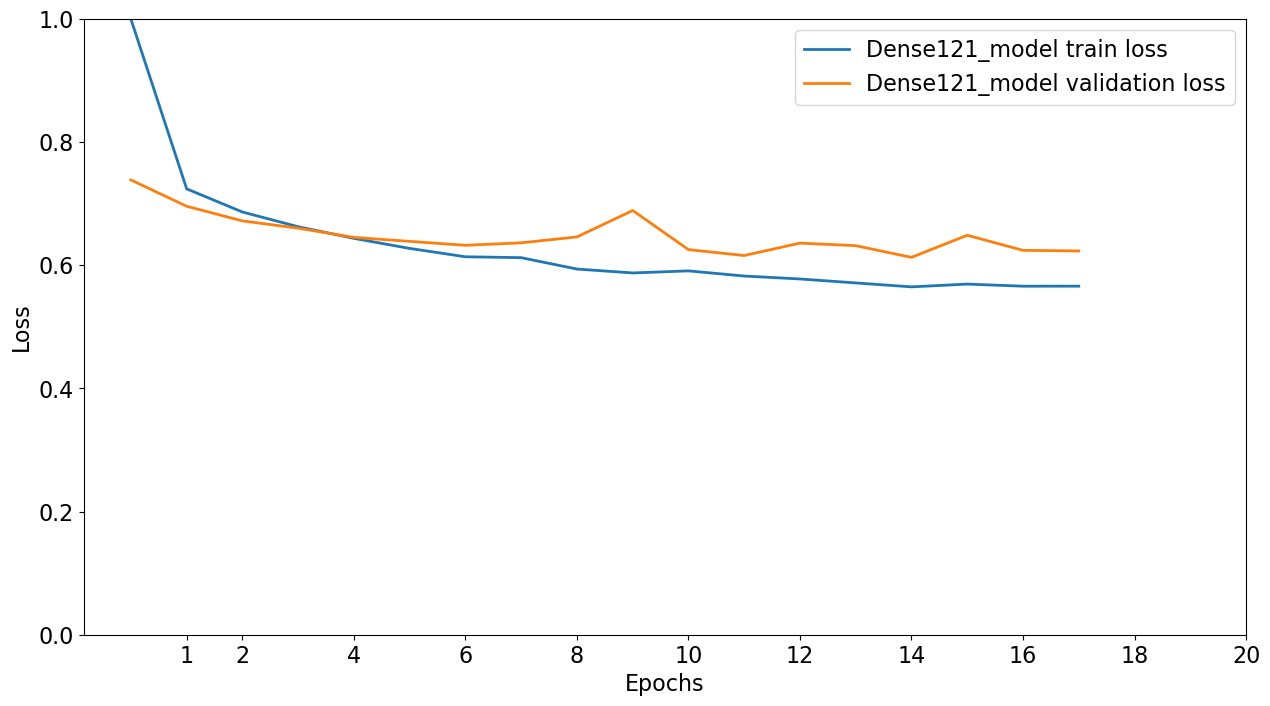

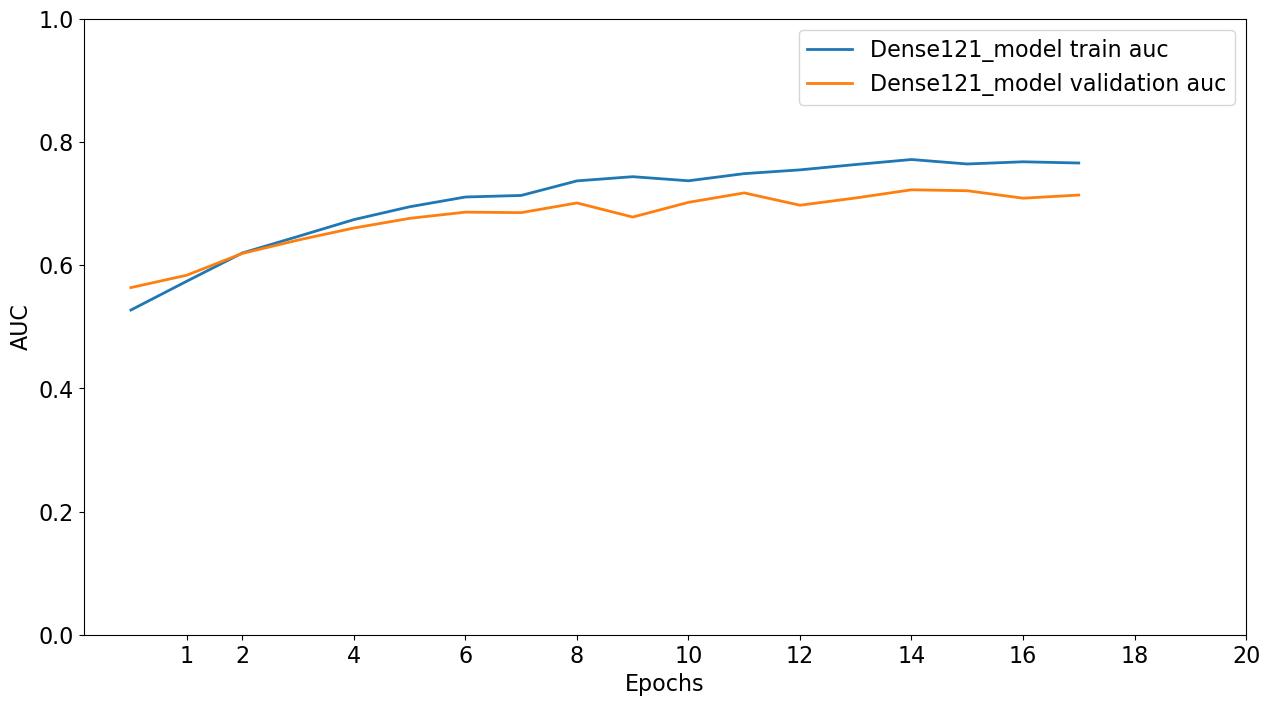

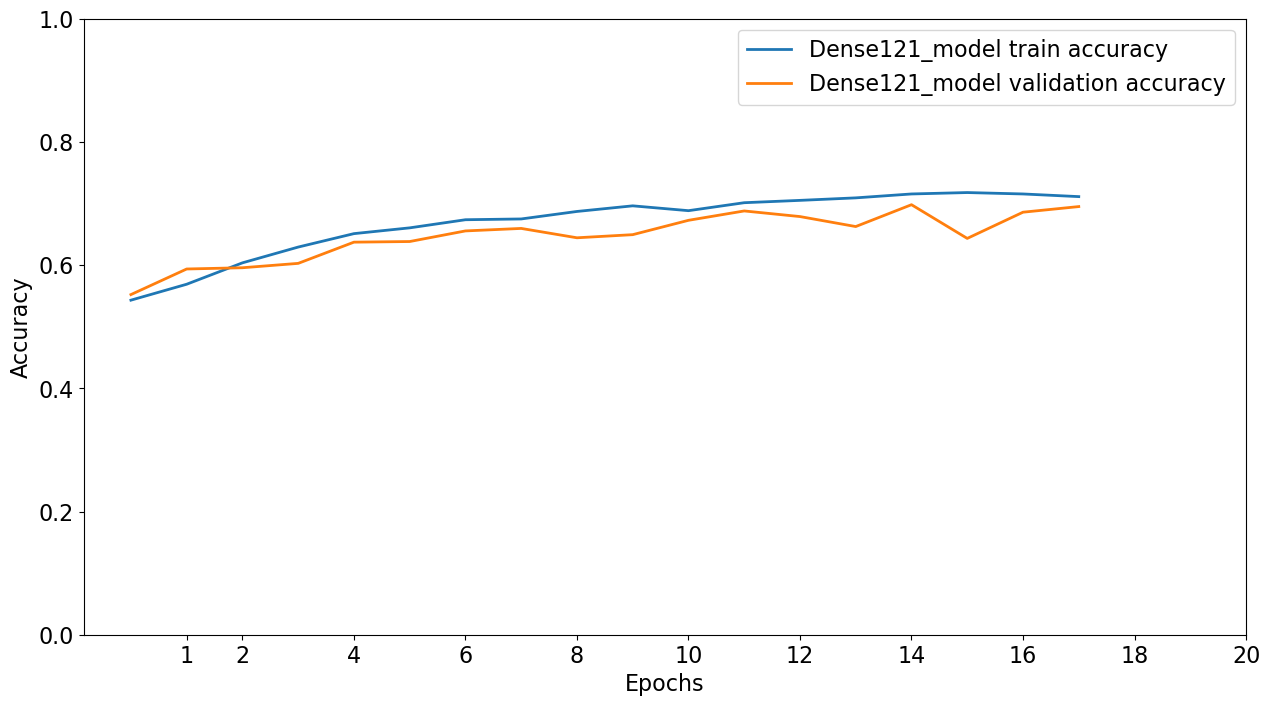

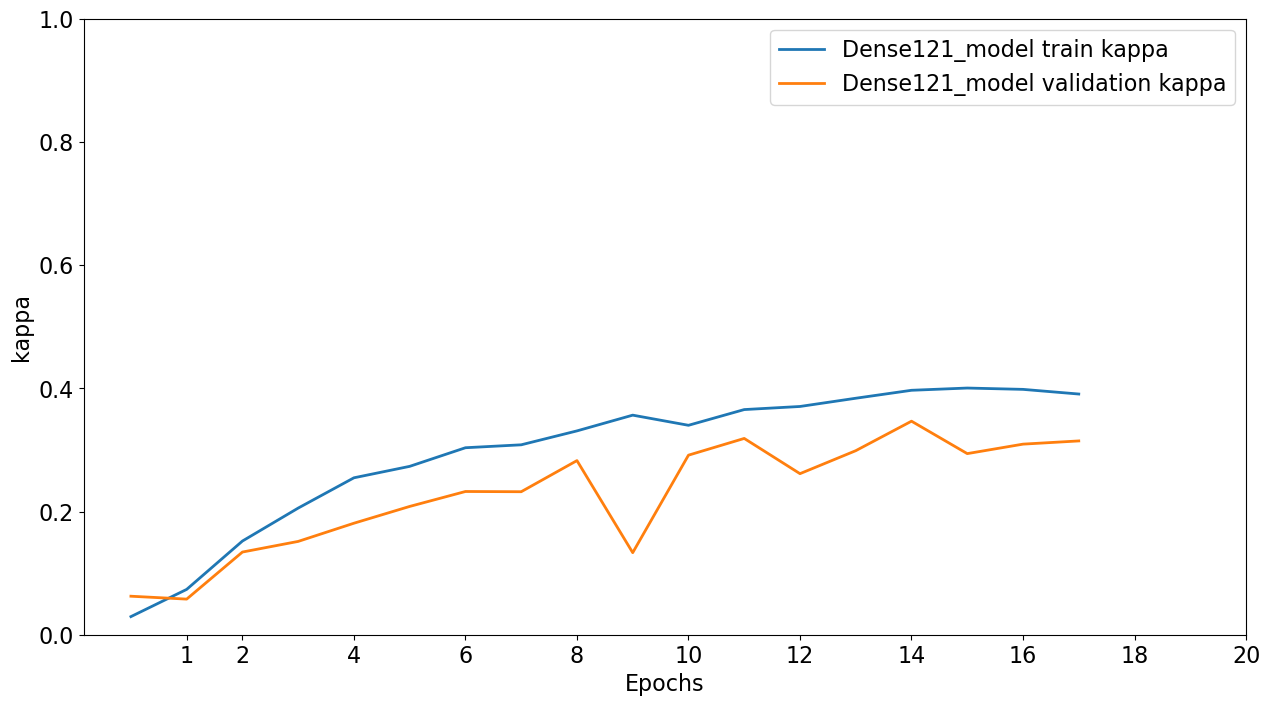

In [36]:
epochs = 20
dense_model.compile(optimizer=Adam(learning_rate= 0.001), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = dense_model.fit_generator(train_generator,validation_data = valid_generator, epochs = epochs,callbacks= my_callbacks)
print('Finished training.')
print('------------------')
dense_model.summary()
filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_DenseNet121Final_ORG.h5'
#filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_DenseNet121Final_CLAHE.h5'
dense_model.save(filename)
print('>Saved %s' % filename)
dense_model_eval = dense_model.evaluate(test_generator)
clean_up(model=dense_model)
print_results(model_name='Dense121_model',epochs= epochs,hs = hs,model_eval = dense_model_eval)

## Applying Confusion Matrix

### Train Data

62/62 [==============================] - 334s 5s/step


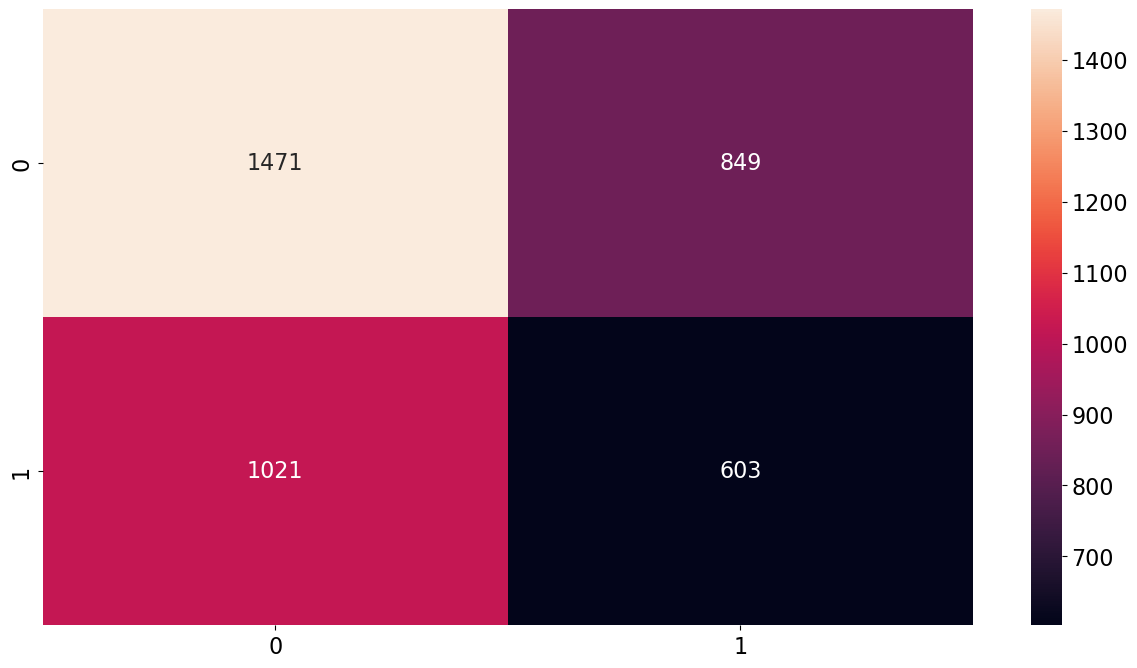

In [37]:
y_pred_train= dense_model.predict(train_generator) # validate Predictions
y_train = train.label_index.values
y_pred_train_binary = [1 if val >= 0.5 else 0 for val in y_pred_train.ravel()]
cm = confusion_matrix(y_train,y_pred_train_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [38]:
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 603
True Negatives: 1471
False Positives: 849
False Negatives: 1021


### Valid Data

16/16 [==============================] - 84s 5s/step


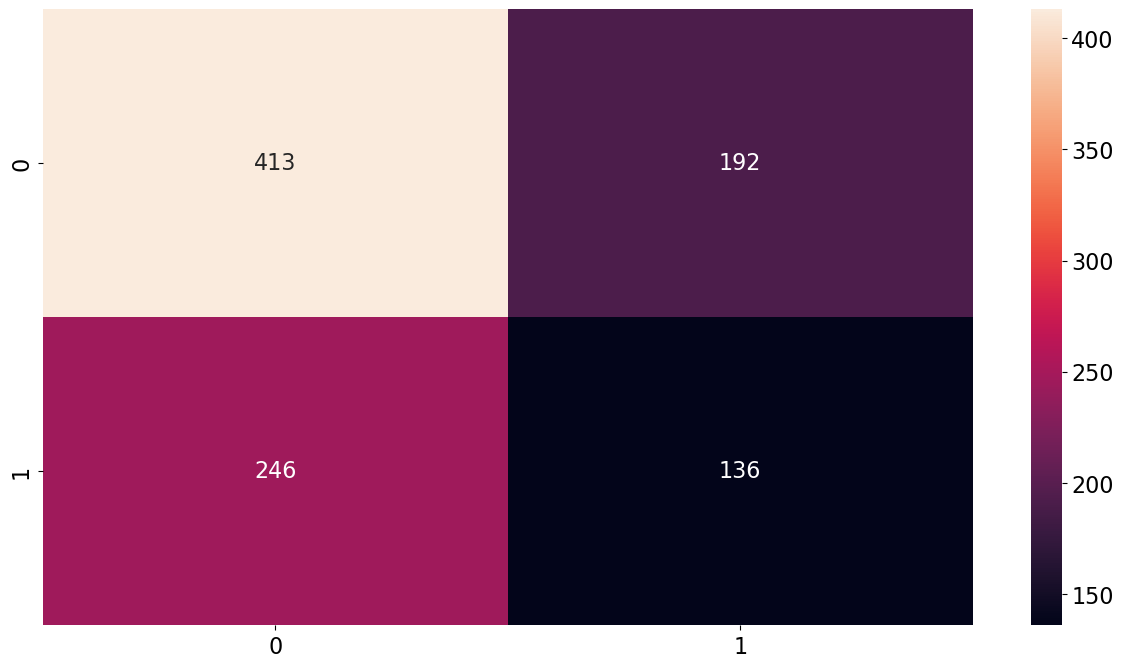

In [39]:
y_pred_valid= dense_model.predict(valid_generator)
y_valid = valid.label_index.values
y_pred_binary = [1 if val >= 0.5 else 0 for val in y_pred_valid.ravel()]
cm = confusion_matrix(y_valid,y_pred_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [40]:
tn, fp, fn, tp = confusion_matrix(y_valid,y_pred_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 136
True Negatives: 413
False Positives: 192
False Negatives: 246


### Test Data

8/8 [==============================] - 38s 5s/step


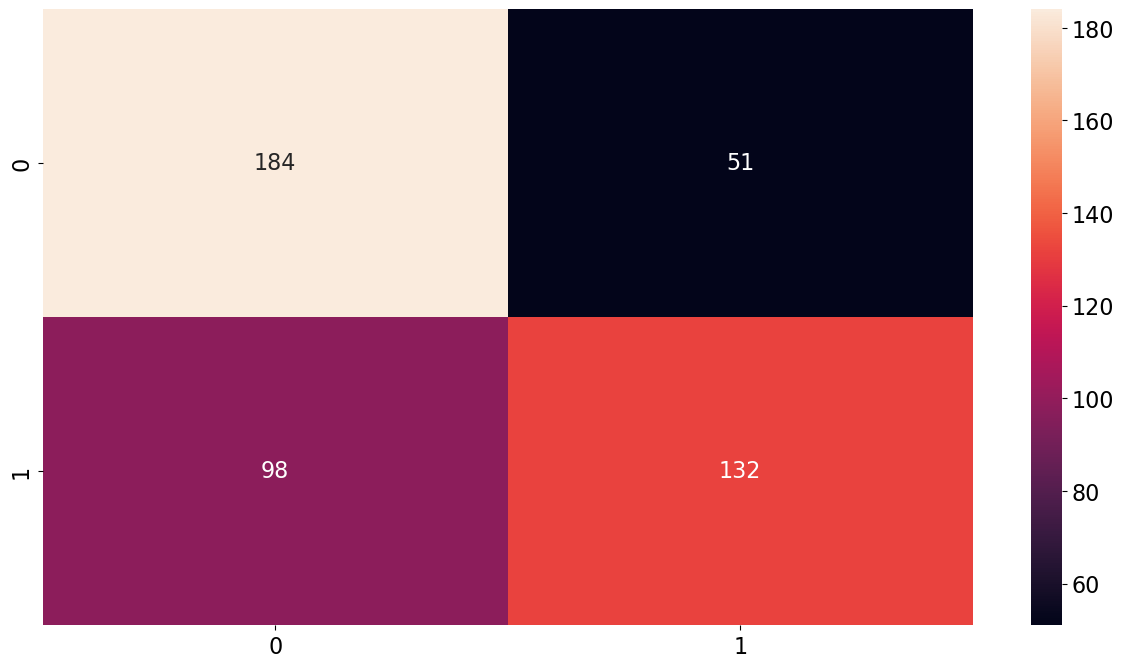

In [41]:
y_pred_test=  dense_model.predict(test_generator) 
y_test = test.label_index.values
y_pred_test_binary = [1 if val >= 0.5 else 0 for val in y_pred_test.ravel()]
cm = confusion_matrix(y_test,y_pred_test_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [42]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 132
True Negatives: 184
False Positives: 51
False Negatives: 98


# Esemble Model (ResNet50, VGG16, DenseNet121)

In [49]:
def load_all_models_eval():
    list_model  = ['model_RESNET50Final_ORG','model_VGG16Final_ORG','model_DenseNet121Final_ORG']
    for name in list_model:
        filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/' + name + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ name
        model_eval = model.evaluate(test_generator)
        clean_up(model=model)
        clean_up(model=model_eval)

In [50]:
load_all_models_eval()

/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_RESNET50Final_ORG.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_RESNET50Final_ORG.h5
8/8 [==============================] - 48s 6s/step - loss: 0.5203 - auc: 0.8294 - accuracy: 0.7484 - kappa: 0.4953
...Finished clean up...
...Finished clean up...
/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_VGG16Final_ORG.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_VGG16Final_ORG.h5
8/8 [==============================] - 115s 14s/step - loss: 1.9632 - auc: 0.7523 - accuracy: 0.7161 - kappa: 0.4307
...Finished clean up...
...Finished clean up...
/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_DenseNet121Final_ORG.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_

In [51]:
def ens_all_models_load():
    all_models = list()
    list_model  = ['model_RESNET50Final_ORG','model_VGG16Final_ORG','model_DenseNet121Final_ORG']
    for name in list_model:
        filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/' + name + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ name
        #os.chdir('/kaggle/input/mura-v11')
        all_models.append(model)
        clean_up(model=model)

    return all_models

def ensembleModels(models, model_input,nameip):
    yModels=[model(model_input) for model in models]
    yAvg=average(yModels)
    modelEns = Model(inputs=model_input, outputs=yAvg, name=nameip)

    return modelEns

def ens_all_models():
    members = ens_all_models_load()
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEns = ensembleModels(members, model_input,"modelEnsemble")
    return modelEns

In [52]:
from tensorflow.keras.layers import average
modelEns = ens_all_models()

/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_RESNET50Final_ORG.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_RESNET50Final_ORG.h5
...Finished clean up...
/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_VGG16Final_ORG.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_VGG16Final_ORG.h5
...Finished clean up...
/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_DenseNet121Final_ORG.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_DenseNet121Final_ORG.h5
...Finished clean up...
Loaded 3 models


In [53]:
epochs = 15
modelEns.compile(optimizer=Adam(learning_rate= 0.001), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = modelEns.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks= my_callbacks)
print('Finished training.')
print('------------------')
modelEns.summary()
# filename = 'C:/KNNT/Personal/Freelance/MURA_trained/finalModel/model_Essemble1.h5'
# modelEns.save(filename)
# print('>Saved %s' % filename)
# modelEns_eval = modelEns.evaluate(test_generator)
# clean_up(model=modelEns)
# print_results(model_name='Ensemble_model',epochs= epochs,hs = hs,model_eval = modelEns_eval)

Epoch 1/15
62/62 [==============================] - 1774s 29s/step - loss: 0.4444 - auc: 0.8831 - accuracy: 0.8096 - kappa: 0.5965 - val_loss: 0.4952 - val_auc: 0.8264 - val_accuracy: 0.7781 - val_kappa: 0.5182 - lr: 0.0010
Epoch 2/15
62/62 [==============================] - 1765s 29s/step - loss: 0.3665 - auc: 0.9301 - accuracy: 0.8633 - kappa: 0.7134 - val_loss: 0.4933 - val_auc: 0.8410 - val_accuracy: 0.7508 - val_kappa: 0.4880 - lr: 0.0010
Epoch 3/15
62/62 [==============================] - 1766s 29s/step - loss: 0.3642 - auc: 0.9293 - accuracy: 0.8633 - kappa: 0.7133 - val_loss: 0.4892 - val_auc: 0.8268 - val_accuracy: 0.7761 - val_kappa: 0.5162 - lr: 0.0010
Epoch 4/15
62/62 [==============================] - 1770s 29s/step - loss: 0.3355 - auc: 0.9462 - accuracy: 0.8818 - kappa: 0.7524 - val_loss: 0.4936 - val_auc: 0.8270 - val_accuracy: 0.7801 - val_kappa: 0.5114 - lr: 0.0010
Epoch 5/15
62/62 [==============================] - 1763s 29s/step - loss: 0.3342 - auc: 0.9444 - accura

In [54]:
for i in range(len(modelEns.weights)):
    modelEns.weights[i]._handle_name = modelEns.weights[i].name + "_" + str(i)

filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_Essemble_ORG.h5'
modelEns.save(filename)
print('>Saved %s' % filename)
modelEns_eval = modelEns.evaluate(test_generator)
clean_up(model=modelEns)
print_results(model_name='Ensemble_model',epochs= epochs,hs = hs,model_eval = modelEns_eval)

ValueError: Unable to create dataset (name already exists)

8/8 [==============================] - 169s 20s/step


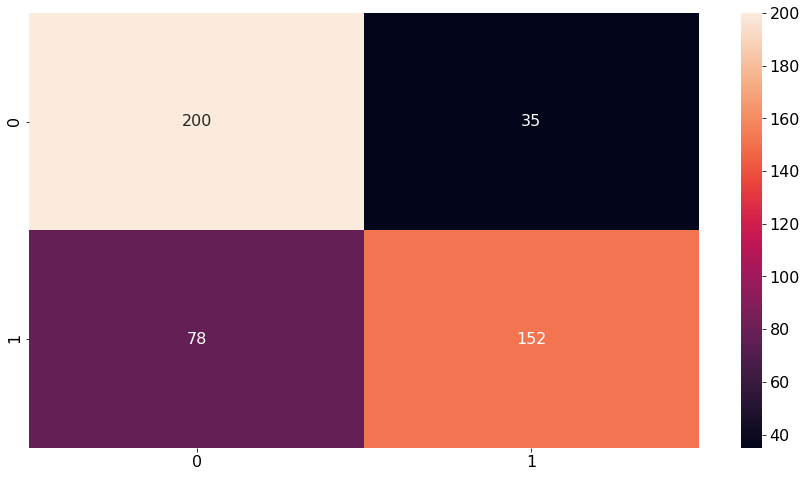

In [55]:
filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_Original/MURA-v1.1/Models_For_Ensemble/model_Essemble_ORG.h5'
modelEnsemble = load_model(filename,custom_objects={'metrics':metrics})
y_pred_test=  modelEnsemble.predict(test_generator) 
y_test = test.label_index.values
y_pred_test_binary = [1 if val >= 0.5 else 0 for val in y_pred_test.ravel()]
cm = confusion_matrix(y_test,y_pred_test_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

8/8 [==============================] - 188s 21s/step - loss: 0.4857 - auc: 0.8447 - accuracy: 0.7570 - kappa: 0.5130
...Finished clean up...
Train Loss     : 0.27088
Validation Loss: 0.47958
Test Loss      : 0.48572
---
Train AUC     : 0.97325
Validation AUC: 0.84345
Test AUC      : 0.84474
---
Train Accuracy     : 0.91912
Validation Accuracy: 0.78217
Test Accuracy      : 0.75699
---
Train Kappa     : 0.83020
Validation Kappa: 0.83020
Test Kappa      : 0.51295


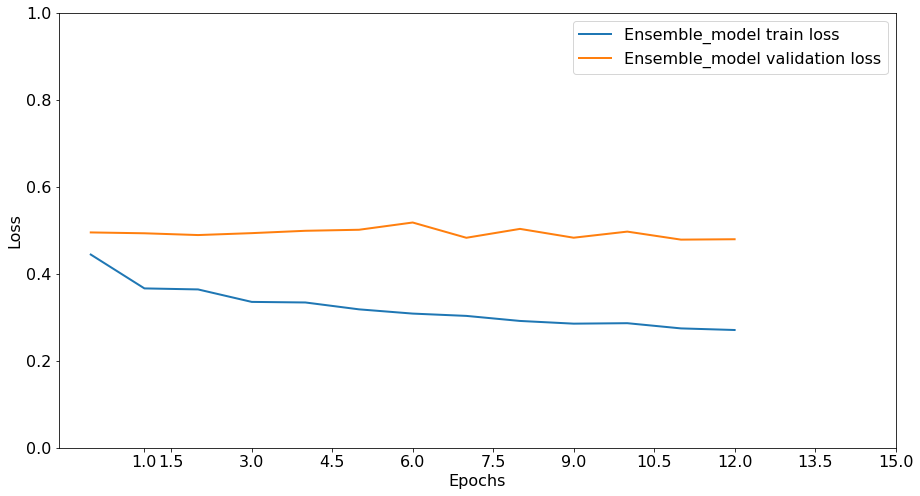

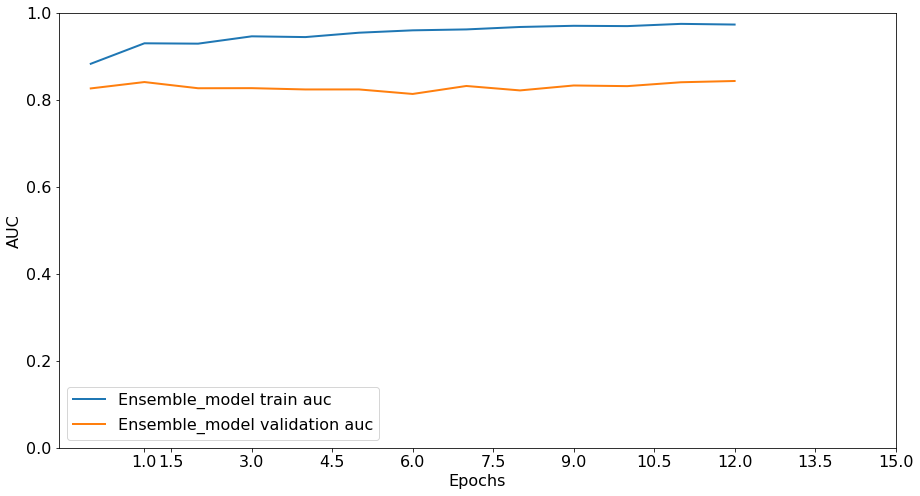

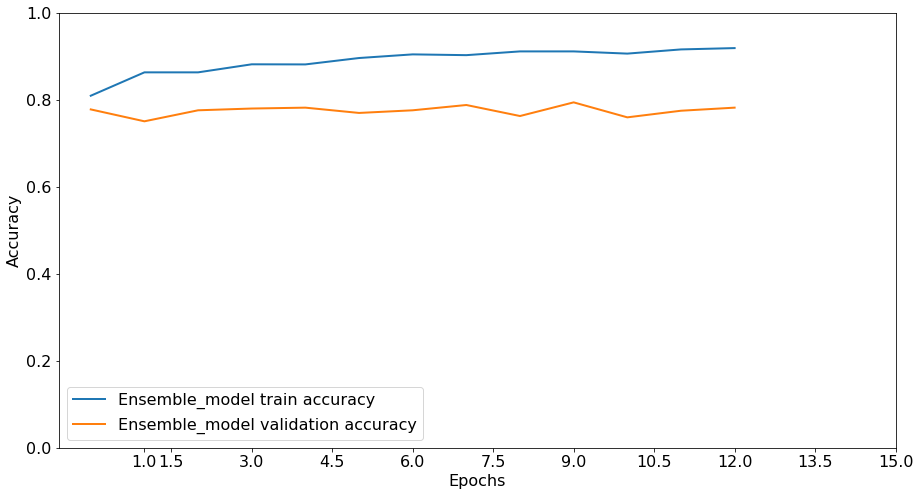

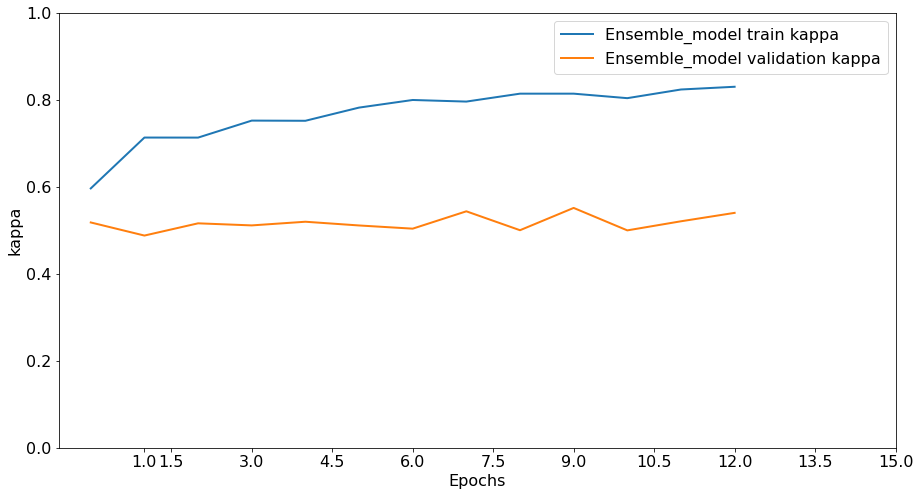

In [56]:
modelEnsemble_eva = modelEnsemble.evaluate(test_generator)
clean_up(model=modelEnsemble)
print_results(model_name='Ensemble_model',epochs= epochs,hs = hs,model_eval = modelEnsemble_eva)

## Applying Confusion Matrix

### Train Data

62/62 [==============================] - 1520s 24s/step


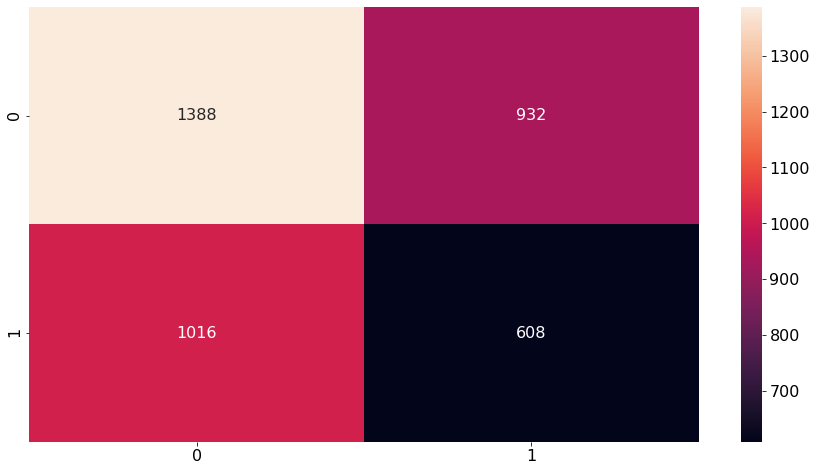

In [57]:
y_pred_train= modelEns.predict(train_generator) # validate Predictions
y_train = train.label_index.values
y_pred_train_binary = [1 if val >= 0.5 else 0 for val in y_pred_train.ravel()]
cm = confusion_matrix(y_train,y_pred_train_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [58]:
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 608
True Negatives: 1388
False Positives: 932
False Negatives: 1016


### Valid Data

16/16 [==============================] - 361s 22s/step


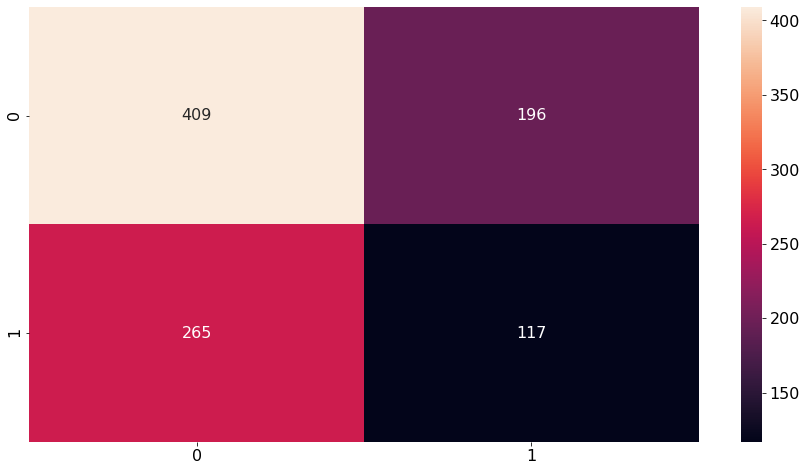

In [59]:
y_pred_valid= modelEns.predict(valid_generator)
y_valid = valid.label_index.values
y_pred_binary = [1 if val >= 0.5 else 0 for val in y_pred_valid.ravel()]
cm = confusion_matrix(y_valid,y_pred_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [60]:
tn, fp, fn, tp = confusion_matrix(y_valid,y_pred_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 117
True Negatives: 409
False Positives: 196
False Negatives: 265


### Test Data

8/8 [==============================] - 173s 21s/step


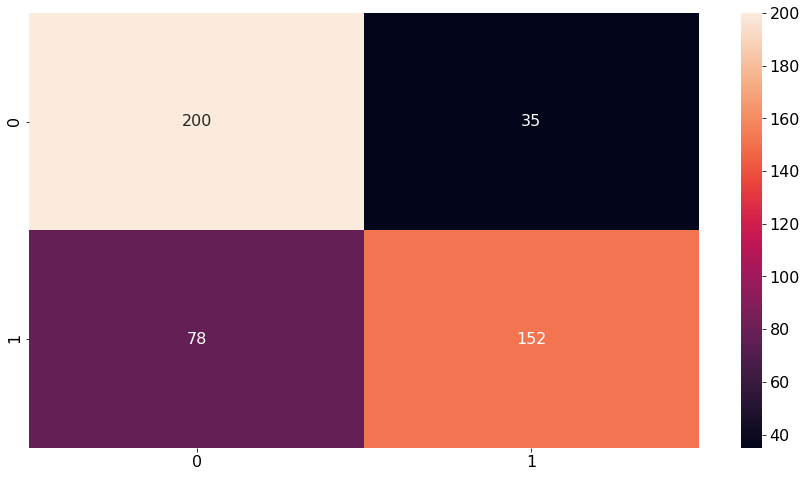

In [61]:
y_pred_test=  modelEns.predict(test_generator) 
y_test = test.label_index.values
y_pred_test_binary = [1 if val >= 0.5 else 0 for val in y_pred_test.ravel()]
cm = confusion_matrix(y_test,y_pred_test_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [62]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 152
True Negatives: 200
False Positives: 35
False Negatives: 78


# End of Project